In [1]:
from astropy import units as u
from astropy.io import fits
from hiresprv.auth import login
from hiresprv.idldriver import Idldriver
from hiresprv.database import Database
from hiresprv.download import Download
from PyAstronomy import pyasl
from specutils.fitting import fit_generic_continuum
from specutils.spectra import Spectrum1D
from scipy import interpolate 

import numpy as np
import pandas as pd 

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline


In [3]:
fluxes = pd.read_csv("fluxes_for_HIRES.csv")
wl = pd.read_csv("interpolated_wl.csv").to_numpy().T[0]

In [5]:
telluric = np.genfromtxt('../spocData/telluric_mask.txt')
#wl_t = np.genfromtxt("../spocData/wavelengths_flat.txt") #Shape: (64336,) 

In [11]:
fluxes.to_numpy().T[0]

array([0.81652139, 0.81730869, 0.8292171 , ..., 0.86281718, 0.85349594,
       0.85306928])

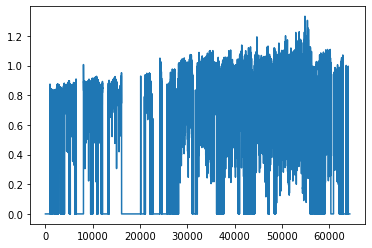

In [12]:
plt.plot(telluric*fluxes.to_numpy().T[0])
plt.show()

In [33]:
telluric_func = interpolate.interp1d(wl_t, telluric)

In [34]:
#print(min(wl_t))
wl = wl[wl > min(wl_t)]
wl = wl[wl < max(wl_t)]
#print(min(wl))
telluric_func(wl)

array([0., 0., 0., ..., 0., 0., 0.])

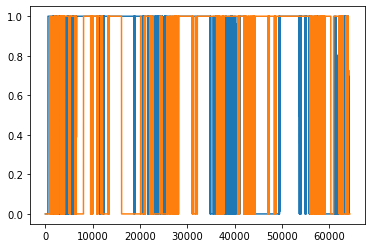

In [37]:
plt.plot(telluric_func(wl))
plt.plot(telluric)
plt.show()

In [4]:
ivar = pd.read_csv("ivar_for_HIRES.csv")

In [6]:
Transposed_fluxes = fluxes.to_numpy()

In [8]:
Transposed_fluxes

array([[0.9710966 , 0.9020379 , 0.96361998, ..., 0.90846168, 0.98028383,
        0.98386708],
       [0.96576846, 0.90436772, 0.95273682, ..., 0.90493699, 0.96067591,
        0.9255858 ],
       [0.96572826, 0.87629715, 0.92220264, ..., 0.88712317, 0.93581402,
        0.86171943],
       ...,
       [0.81934231, 0.92964789, 0.7868808 , ..., 0.90655942, 0.78910614,
        0.88763744],
       [0.82098285, 0.93573745, 0.7756256 , ..., 0.9010167 , 0.79600519,
        0.87000295],
       [0.83080429, 0.91857009, 0.77252446, ..., 0.88031707, 0.80112382,
        0.84131948]])

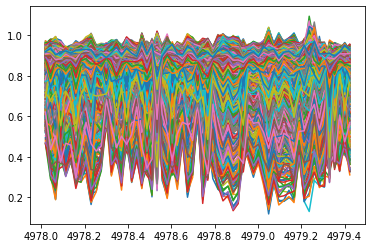

In [9]:
i = 0
for flux in Transposed_fluxes:
    plt.plot(wl[0:61],flux[1:62])
    if i == 800:
        break
    else:
        i+= 1
    
plt.show()

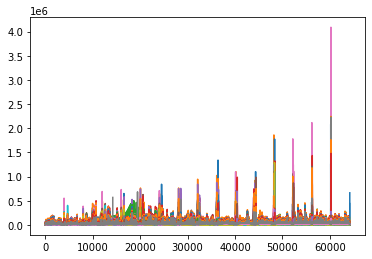

In [10]:
i = 0
for var in ivar.T.to_numpy():
    plt.plot(var)
    if i == 800:
        break
    else:
        i+=1
plt.show()

In [11]:
keck_hires_cell = pd.read_csv("keck_iodine_cell.csv",header=None)

In [23]:
wl, flux = keck_hires_cell.to_numpy().T[0],keck_hires_cell.to_numpy().T[1]

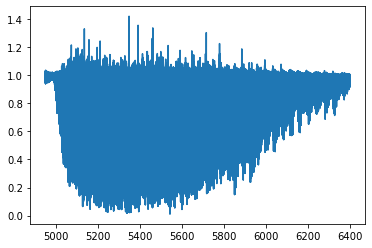

In [31]:
plt.plot(wl,flux)
plt.show()

In [16]:
flux

array([4.9500039e+03, 9.7771833e-01])